### Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях

1. Поиск гиперпараметров:
    - Поиск по сетке(Grid Search, Randomized Search)
    - Покоординатный спуск(Coordinate Search)
    - Генетические алгоритмы(Genetic Algorithms) - создат несколько объектов гиперпараметров и будет выбирать исходят из уменьшения функции потерь
    - Байесовская оптимизация (ПРИМЕР ПОКАЗАН В HYPEROPT)
    

2. Теоретическая часть:
    - Проблема интерпретируемости моделей
    - Примеры, когда это важно
    - Обзор методов
    

3. Практическая часть:
    - Feature importance, доступный в самих моделях
    - Permutation Importance
    - SHAP

#### Байесовская оптимизация:
- Построить суррогатную вероятностную модель целевой функции
- Найти гиперпараметры, которые лучше всего работают на суррогате
- Применить эти параметры к истинной целевой функции
- Обновить суррогатную модель, включающую новые результаты
- Повторить шаги 2-4, пока не будет достигнуто максимальное количество итерации или время

Будет затронут важный для любого бизнеса, применяющего машинное обучение при решении задач, аспект - интерпретируемость моделей. Т.е важно не только умение обучать модели, которые делают качественные прогнозы, но и умение объяснить эти прогнозы. Когда мы не просто понимаем, что пользователь склонен совершить некоторое действие (например, уйти в отток), но и можем выявить факторы, влияющие на это, что позволяет скорректировать стратегию взаимодействия с пользователями (как пример). Такая модель может быть полезна не только своими прогнозами, но и инсайтами, которые скрыты в данных. 

### Проблема интерпретируемости моделей машинного обучения

Интерпретируемость – это возможность объяснить прогнозы модели на понятном бизнесу языке

Черный ящик (так часто видят ML)

![ab_split](blackbox.png "blackbox ML")

Особенности:

1. мы получаем прогнозы, которые приносят пользу (ну, должны)
2. мы не можем внятно объяснить почему прогнозы именно такие и что именно повлияло на принятие решения модели

![ab_split](blackbox2.png "blackbox ML + inter")

Интерпретация прогнозов модели может дать интересные инсайты о том, какая у нас аудитория (вспоминаем uplift-моделирование)

Иногда же на практике интерпретируемость является критичным моментом

Как выглядит процесс: 

1. есть реальный мир
2. мы векторизуем его (как можем - получаем признаки)
3. строим модель
4. интерпретируем
5. объясняем людям поведение модели


![ab_split](inter2.png "inter1")

![ab_split](inter1.png "inter1")

* картинка взята с https://habr.com/ru/company/otus/blog/464695/

### Обзор методов

- важные признаки в модели (feature importance)
- влияние каждого отдельного признака на конкретный прогноз 
- влияние каждого признака на большое количество возможных прогнозов (топ k наблюдений, например)

### 1. Feature importance признаков

Пример с линейной моделью

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("kc_house_data.csv")
print(df.shape)
df.head(3)

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [64]:
features = ["bedrooms", "sqft_living", "sqft_lot", "yr_built"]
target = "price"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

Соберем пайплайн

In [65]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [66]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [67]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bedrooms',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('yr_built',
                                                 Pipeline(memory=None,
                          

Посчитаем MAE и коэффициент детерминации (R2)

In [68]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.4957386194, 0.5365765901167385)

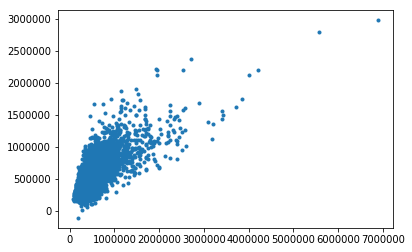

In [70]:
import matplotlib.pyplot as plt

plt.plot(y_test, predictions,'.')
plt.show()

mae малоинформативен, но вот r2 - очень понятен.

На случай, если кто забыл:

![r2](r2.png "R2 score")

Интерпретация:

1. принимает значения от -1 до 1. Чем ближе к 1, тем лучше модель объясняет данные (соответствует модели данных)
2. значение 1 означает функциональную зависимость y от X
3. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше

источник на вики - https://ru.wikipedia.org/wiki/Коэффициент_детерминации

Наконец, давайте посмотрим на "важность" признаков (в линейной регрессии это просто веса (коэффициенты) при предикторах (признаках)

Сразу же возьмем абсолютные значения коэффициентов

In [71]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.head()

,coefficient
bedrooms,-55705.016661
yr_built,-71039.334129
sqft_living,316113.766523
sqft_lot,-14820.959494


Как это можно интерпретировать:

1. sqft_living имеет наибольшую важность и положителен (чем выше жилая площадь, тем выше стоимость)
2. остальные признаки уже идут с отрицательным весом
3. вторым по важности признаком является год постройки (yr_built)

### Перейдем к "деревянным" моделям

In [72]:
import xgboost as xgb

In [73]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Series.base is deprecated and will be removed in a future version


[21:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bedrooms',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('yr_built',
                                                 Pipeline(memory=None,
                          

In [74]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(147512.7954061806, 0.6125861289964616)

In [75]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

,coefficient
bedrooms,0.037282
yr_built,0.131452
sqft_living,0.750951
sqft_lot,0.080315


Как можно считать feature_importance в моделях на базе деревьев решений

![xgboost](xgboost_tree.png "Xgboost tree")

Ссылка (рекомендую поизучать на досуге) - https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Существует несколько вариантов как для признака в деревьях решений посчитать важность

1. Gain - показывает относительный вклад каждой фичи в модель. 
Алгоритм простой - идем по каждому дереву, смотрим в каждом узле дерева по какому признаку происходит разбиение узла и насколько снижаетcя неопределенность (gini impurity, information gain). Далее для каждого признака суммируется её вклад (по всем деревьям)

2. Frequency - показывает, как часто конкретный признак встречается в узлах дерева, то есть считается суммарное количество разбиений дерева на узлы для каждого признака в каждом дереве.

<b>Вопрос:</b>
Какие еще вы знаете модели со "встроенной" возможностью определять важность признаков?

Ваш ответ:

#### Краткий вывод:

Подходы, основанные на feature_importance, очень удобны, т.к по факту мы получаем готовый функционал и можем хоть какую-то интерпретацию давать без каких-либо внешних инструментов.

Однако проблема такого подхода заключается в том, что непонятно, как именно данная фича влияет на итоговый прогноз. 

Пример: жилая площадь важна для прогноза стоимости жилья, но как именно это может быть связано с другими признаками? Это будет в пункте 3, а сейчас давайте рассмотрим еще один (из множества) способ расчета "важности" признаков

### 2. Permutation importance

Алгоритм очень простой:

- обучаем модель на тренировочном наборе данных
- проверяем качество на валидации
- для валидационного набора данных перемешиваем один из признаков
- снова проверяем качество на нем же

Признак считается «важным», если качество модели падает при его перемешивании.

Очень удобно, что в sklearn есть возможность из коробки такое делать

In [44]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

Пример как это может выглядеть на выходе

In [45]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

yr_built 1.441 +/- 0.042
sqft_lot 0.095 +/- 0.010
sqft_living 0.048 +/- 0.004
bedrooms 0.012 +/- 0.002


Интересно, что результаты немного другие, нежели при использовании "встроенного" feature_importances_)

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

### SHAP

ссылка на проект - https://github.com/slundberg/shap

Wiki - https://en.wikipedia.org/wiki/Shapley_value

Значения Шэпли пришли к нам из теории игр.

Пример - группа людей (далее - коалиция) играет в игру. 

Необходимо распределить призовой фонд между ними в зависимости от их вклада.

Уточнения (допущения):

- игроки с равным вкладом должны получить одинаковую награду
- если вклад игрока нулевой, то награда также нулевая
- если игрок провел несколько игр, то его награда - это сумма наград за каждую из игр

Немного математики (ссылка - https://en.wikipedia.org/wiki/Shapley_value)

![shap2](shap2.png "SHAP 1")

u - это выигрыш команды

n - количество игроков

S - коалиция (подмножество из n без игрока i)

А теперь попробуем "переложить" все это на вариант с задачей обучения с учителем

- игра - результат обучения с учителем (на основе заданного примера)
#- выигрыш – это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере
- вклады игроков в игру – влияние каждого значения признака на выигрыш, т.е. результат.

Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (каждого наблюдения) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи.

Расчет SHAP values очень тяжелый и затратный как по времени так и по ресурсам!

![ab_split](shap1.png "SHAP 1")

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. 

Он основан на Векторе Шепли - принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу (https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80). 

### Игрушечный пример 

![shap4](shap4.png "SHAP 4")

На выходе для комбинации {Fever=Yes, Cough=Yes} хотим получить значимость признаков (т.е для конкретного наблюдения). 

Посчитаем выход модели для каждой возможной комбинации признаков:

![shap4](shap3.png "SHAP 3")

Теперь посчитаем SHAP для признака Fever для модели А (левое дерево).

Для этого посчитаем все необходимое для комбинаций признаков, которые не включают Fever:
![shap4](shap5.png "SHAP 5")

таких у нас 2:
![shap4](shap6.png "SHAP 6")

Подставляем значения в формулу и получаем SHAP для признака Fever:

![shap7](shap7.png "SHAP 7")

А теперь для признака Cough:

![shap8](shap8.png "SHAP 8")

Для модели B (дерево справа) получаем такое:

![shap9](shap9.png "SHAP 9")

Получаем значимость признаков на уровне одного примера с конкретными значениями признаков. 

* phi_0 - ожидаемый результат (для первой модели мы можем попасть в один из 4 листьев - ответ 20, для второй - 25)
* phi - ответ модели для конкретного наблюдения ({Fever=True, Cough=True}) - для первой модели 80, для второй - 90

### Пример объяснения решений деревьев при помощи SHAP(значение Шэпли)

In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Exited'], random_state=0)

In [4]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Мы видим, какой признак какой вклад сделал для этой модели(тут вклад имеется ввиду точка 0.35):
 - красные увеличивают
 - синие - уменьшают
 
 
Посмотрим на другой объект(номер 100)

In [10]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[100,:], X_train.iloc[100,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

In [12]:
# просто посмотрим на сами значения
# Они демонстрируют, на сколько много информации принес признак с соответствующим значением и его влияние на результат
shap_values

array([[ 6.9390715e-04, -1.9440489e-02, -2.9842521e-03, ...,
         3.2651721e-04,  2.7593097e-02,  8.4632408e-04],
       [-1.4914877e-03, -8.0312058e-02,  3.1678393e-04, ...,
        -1.9320374e-04,  2.4653178e-02, -9.7894296e-04],
       [-1.6520806e-03, -5.6121752e-02, -2.7130486e-03, ...,
        -3.5538420e-04, -2.1113668e-02, -1.2023647e-03],
       ...,
       [-5.7603262e-04, -7.0252903e-02, -6.9325056e-04, ...,
        -1.3481938e-04,  2.7778365e-02,  1.9120728e-03],
       [ 1.0101115e-02, -2.3651039e-02, -2.0087943e-03, ...,
        -3.2092127e-04, -1.9861013e-02, -1.6948277e-03],
       [-1.4369480e-03,  1.8059985e-01,  2.6211156e-02, ...,
        -3.3890782e-04,  6.4552151e-02, -1.1157003e-03]], dtype=float32)

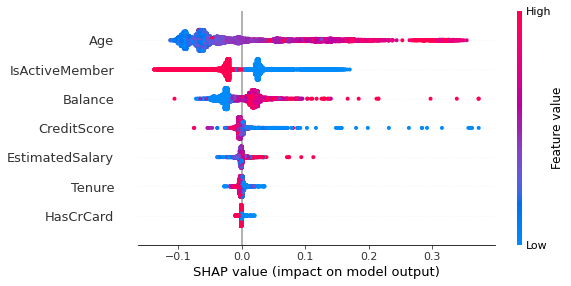

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем старше человек, тем выше вероятность ухода
- чем признак IsActiveMember выше, то вероятность ухода ниже
- чем выше баланс, тем выше вероятность ухода (?)

Посмотрим на значение вектора Шэпши для признака вдоль изменения значений признака в зависимости от признака "Активность"

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


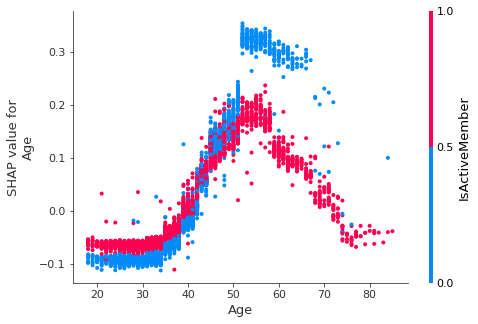

In [15]:
shap.dependence_plot('Age', shap_values, X_train)

Можно даже просто взять средние значения SHAP для каждого признака

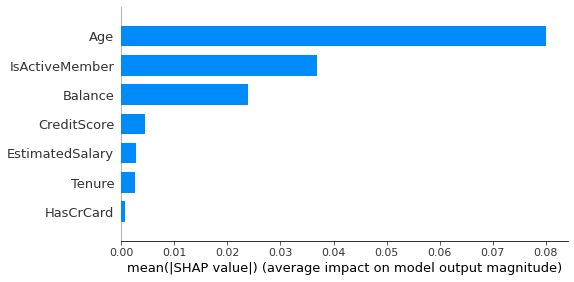

In [6]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Ниже представлена возможность посмотреть поведение признаков на большом массиве

Она интерактивна. Анализируя ее, можно ответить на многие вопросы 

In [16]:
n = 400
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

In [17]:
shap_values.shape

(7500, 7)

In [9]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], link="logit")